<a href="https://colab.research.google.com/github/runnin123/Jeju_Bigdata/blob/master/Jeju_bigdata_0708.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

project_id = 'jeju-bigquery-282708'
client = bigquery.Client(project=project_id)

train = client.query('''
  SELECT 
      * 
  FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train` 
  WHERE RAND() < 10000 / (SELECT COUNT(*) FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train`)
  ''').to_dataframe()

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 03 Chapter에서 추가
# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  # Matlab-style plotting

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# 06 Chapter 추가
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.22.2.post1
seaborn : 0.10.1
matplotlib : 3.2.2
Python 3.6.9


In [ ]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [ ]:
# 날짜 처리
data = train.copy()
data = data.fillna('')
print(data['REG_YYMM'].head())

0    201902
1    201909
2    202001
3    202003
4    201909
Name: REG_YYMM, dtype: int64


In [ ]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,경기,안산시 단원구,체인화 편의점,강원,강릉시,20s,1,1,24,856000,59,2019,2
1,강원,양양군,차량용 주유소 운영업,강원,양양군,20s,2,1,12,764050,17,2019,9
2,경기,고양시 덕양구,한식 음식점업,강원,춘천시,20s,2,1,4,50900,4,2020,1
3,강원,원주시,기타 외국식 음식점업,강원,원주시,20s,2,2,87,2280800,93,2020,3
4,강원,원주시,서양식 음식점업,강원,속초시,20s,1,1,4,97800,4,2019,9


In [ ]:
# 데이터 정제
df = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [ ]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [ ]:
from sklearn.model_selection import train_test_split

X_data, y_data = df_num.loc[:, df_num.columns != 'AMT'], df.loc[:, df_num.columns == 'AMT']
y_target = y_data['AMT']
X_data = X_data.drop(['CSTMR_CNT', 'CNT'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2, random_state=126, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7547, 8), (7547,), (1887, 8), (1887,))


 mu = 2521698.60 and sigma = 16674628.81



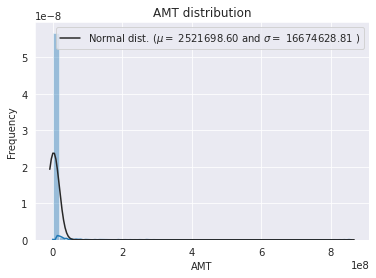

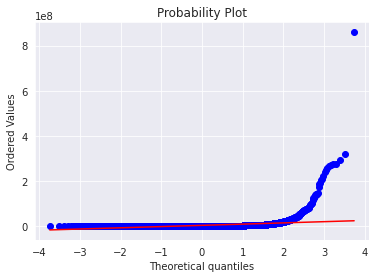

In [ ]:
sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()


 mu = 12.68 and sigma = 1.73



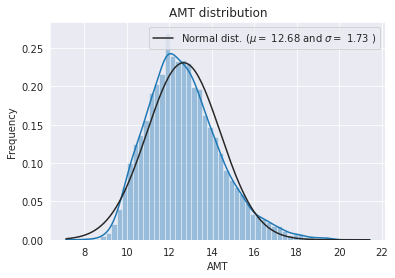

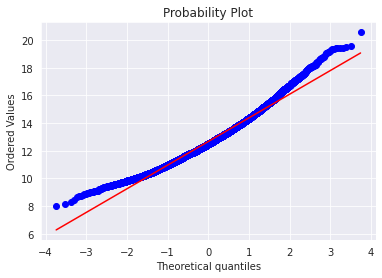

In [ ]:
y_train = np.log1p(y_train)

sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

In [ ]:
from xgboost import XGBRegressor
import xgboost
print(xgboost.__version__)

0.90


In [ ]:
import lightgbm
from lightgbm import LGBMRegressor
print(lightgbm.__version__)

2.2.3


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('Test Data RMSLE: {0:.3f}'.format(rmsle))

In [ ]:
# 교차검증 수행
def get_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train, y_train)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test, eval_pred)
  
  return cv_model.best_estimator_

In [ ]:
from sklearn.linear_model import LinearRegression

# 3개의 모델 선언
xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0) 

params = {'n_estimators': [1000, 1500, 2000],
          'max_depth' : [3, 5, 8],
          'learning_rate' : [0.1, 0.05, 0.01]}

models = [xgb, gbm, lgb] 
best_models = []
for model in models:
  new_model = get_best_params_model(model=model, params=params)
  best_models.append(new_model)

[11:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# 모형 불러오기
xgb_reg = best_models[0]
gbm_reg = best_models[1]
lgb_reg = best_models[2]

# 예측 데이터 세트
xgb_pred = xgb_reg.predict(X_test)
xgb_pred = np.expm1(xgb_pred)

gbm_pred = gbm_reg.predict(X_test)
gbm_pred = np.expm1(gbm_pred)

lgb_pred = lgb_reg.predict(X_test)
lgb_pred = np.expm1(lgb_pred)
pred = np.array([xgb_pred, gbm_pred, lgb_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환
pred = np.transpose(pred)
print(pred.shape)

(3, 1887)
(1887, 3)


In [ ]:
final = xgb_pred*0.50 + gbm_pred*0.20 + lgb_pred*0.30
rmsle(y_test, final)

Test Data RMSLE: 1.495
